In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch import nn

> #### Creating a simple dataset using linear regression

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)

y = (weight * X) + bias

> #### Splitting the data into test and training sets

In [3]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]

> #### Function for visualizing our data 

In [4]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test,
                    test_labels=y_test, predictions=None):
    
    plt.figure(figsize=(8, 6))
    
    plt.scatter(train_data, train_labels, c='blue', s=4, label="Training data")
    
    plt.scatter(test_data, test_labels, c='green', s=4, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c='red', s=4, label="Predictions")
    
    plt.legend()
    plt.show()

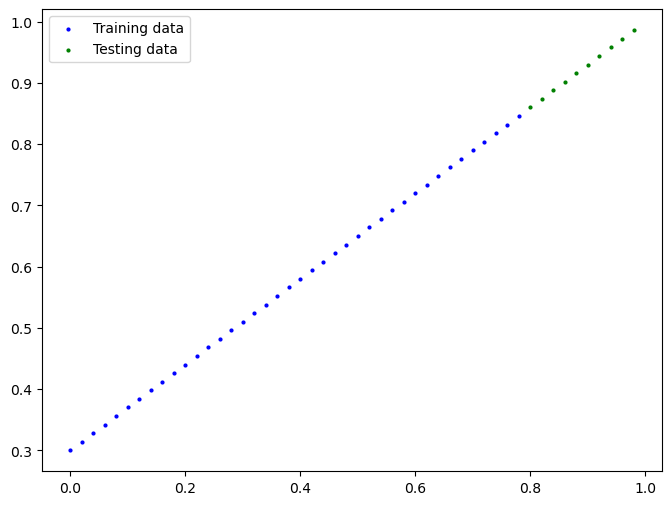

In [5]:
plot_predictions()

> ### nn.Parameter

> What makes nn.Parameter special?
+ When you're building a neural network in PyTorch, you often need to define parameters like weights and biases<br><br>
+ `nn.Parameter` is like a special marker you put on these tensors to tell PyTorch, "Hey, these are the parameters I want to train."<br><br>
+ When you attach an `nn.Parameter` to a PyTorch module (like a layer in your neural network), PyTorch automatically keeps track of it as a parameter of that module<br><br>
+ This automatic tracking makes it easier to manage and train your model because you don't have to manually keep track of which tensors are parameters<br><br><br><br>


> Why not just use regular tensors?
+ Sometimes, you might have other tensors in your model that you don't want to train, like temporary variables or cached states<br><br>
+ If PyTorch treated every tensor as a trainable parameter, it would make training more complicated and less efficient<br><br>
+ So, PyTorch gives you the option to use regular tensors for non-trainable things and `nn.Parameter` for the actual parameters you want to train<br><br>
+ Using `nn.Parameter` helps you clearly distinguish between what should be trained and what's just temporary or non-trainable<br><br><br><br>

+ **NOTES:**
    + The `forward()` method defines the computation performed at every call<br><br>
    + The loss function is the quantity that will be minimized during training while the optimizer determines how the network will be updated based on the loss function<br><br>

> #### Building the model

+ We can create the model parameters using `nn.Linear()` or by:
```
self.weight = nn.Parameter(torch.randn(size=(1, ), requires_grad=True,
                                                              dtype=torch.float32))
                                                              
self.bias = nn.Parameter(torch.randn(size=(1, ), requires_grad=True,
                                                          dtype=torch.float32))
```

<br><br>
+ Similarly, `forward()` method can be like:
```
def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (self.weight * x) + self.bias
```

In [17]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

> #### Loss function
+ We'll be using `nn.L1Loss` which is a simple loss function that measures the mean absoute error between each element in the input $x$ and the target $y$

> ### Training loop

+ A typical training loop consists of:
    + Looping through the data:
        + In this step, each batch of data is passed through the neural network for training. This process ensures that the model learns from a variety of examples, improving its ability to generalize to unseen data. It's crucial for updating the model's parameters iteratively<br><br>

    + Forward pass:
        + During the forward pass, input data is passed through the neural network, layer by layer, to generate predictions. This step computes the output of the model given the current set of parameters. It's essential for computing the loss and updating the model's parameters in the subsequent steps<br><br>
    + Calculating the loss:
        + The loss function measures the discrepancy between the model's predictions and the actual targets. It quantifies how well the model is performing on the given data. By calculating the loss, we can determine the direction in which to adjust the model's parameters to minimize the error<br><br>
    + Optimizer zero grad:
        + Before computing the gradients for the new batch of data, it's necessary to zero out the gradients from the previous batch. This prevents accumulation of gradients across multiple batches, ensuring that each batch's gradients are independent and accurately reflect the loss for that specific batch. Gradient accumulation helps to imitate a larger batch size. Imagine you want to use 32 images in one batch, but your hardware crashes once you go beyond 8. In that case, you can use batches of 8 images and update weights once every 4 batches<br><br>
    + Loss backward:
        + In this step, gradients of the loss function with respect to the model's parameters are computed using backpropagation. Backpropagation efficiently calculates these gradients by propagating the error backwards through the network. These gradients indicate how much each parameter contributed to the loss, guiding parameter updates in the next step<br><br>
    + Optimizer step:
        + The optimizer uses the computed gradients to update the model's parameters in a direction that reduces the loss. Common optimizers like SGD, Adam, or RMSprop adjust the parameters based on the gradients and the chosen optimization algorithm's rules. This step iteratively improves the model's performance by adjusting its parameters to better fit the training data<br><br>
<br><br>
+ **NOTES:**
    + The `eval()` is used during testing of the model. It can be thought as turning off different settings not needed for evaluation or testing of the model
    + The `train()` method is used during training of the model and kind of keeps track of the gradients of the learnable parameters
    + The `torch.inference_mode()` and `torch.no_grad()` turns off gradient tracking and a copule of more things behind the scenes. The inference code also runs faster with this mode turned on
<br><br>

In [33]:
torch.manual_seed(42)

my_model = LinearRegressionModel()
my_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [34]:
learning_rate = 0.01

loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=my_model.parameters(), lr=learning_rate)

In [35]:
epoch_count = []
train_loss_values = []
test_loss_values = []

epochs = 120

for epoch in range(epochs):
    my_model.train()   
    
    y_preds = my_model(X_train)   
    train_loss = loss_fn(y_preds, y_train)    
    optimizer.zero_grad()   
    train_loss.backward()   
    optimizer.step()
    
    my_model.eval()  
    
    with torch.inference_mode():
        test_preds = my_model(X_test)  
        test_loss = loss_fn(test_preds, y_test)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Train Loss: 0.4399680495262146 | Test Loss: 0.4392663538455963
Epoch: 20 | Train Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Train Loss: 0.20954827964305878 | Test Loss: 0.16984674334526062
Epoch: 40 | Train Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
Epoch: 50 | Train Loss: 0.023886386305093765 | Test Loss: 0.04784906655550003
Epoch: 60 | Train Loss: 0.0199567973613739 | Test Loss: 0.04580312222242355
Epoch: 70 | Train Loss: 0.016517987474799156 | Test Loss: 0.0375305712223053
Epoch: 80 | Train Loss: 0.013089170679450035 | Test Loss: 0.029944902285933495
Epoch: 90 | Train Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Train Loss: 0.006215679459273815 | Test Loss: 0.014086711220443249
Epoch: 110 | Train Loss: 0.002787243574857712 | Test Loss: 0.005814164876937866


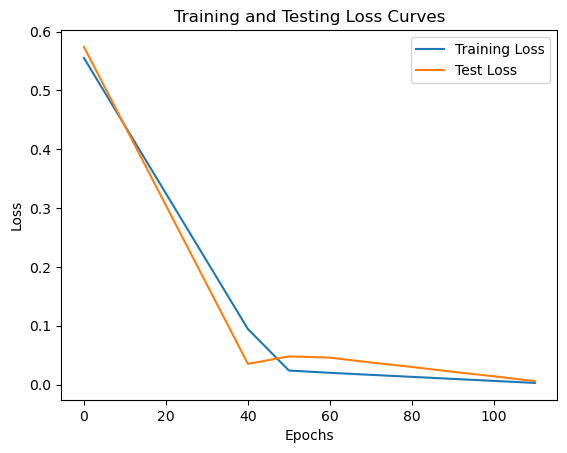

In [36]:
plt.plot(epoch_count, torch.tensor(train_loss_values).detach(), label="Training Loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).detach(), label="Test Loss")
plt.title("Training and Testing Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

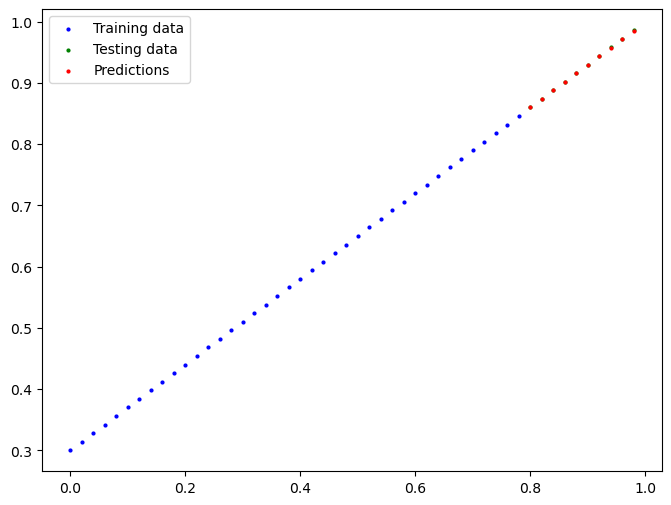

In [47]:
plot_predictions(predictions=test_preds.detach())

> ### Saving and Loading a PyTorch Model
+ There are three core functions that we should be familiar with:
    + `torch.save()`
    + `torch.load()`
    + `torch.nn.Module.load_state_dict()`